In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import Layout
from IPython.display import display, Markdown, Latex

from pathlib import Path

# import tessa.spatial_clustering
import tessa.building_data as bd

from tessa.widgets import MapBrowser


from tessa.core.settings import Settings, TessaCore
from tessa.core.models import District

from tessa.thermal_system_models.models import DistrictNetwork, NetworkCosts, FlowProperties, \
    ThermalSources, ThermalSource

from dotenv import load_dotenv

load_dotenv();

In [3]:
app = TessaCore(config=Settings())
engine = app.database.engine
base_path = Path(app.config.default_data_dir)
test_data_path = base_path / 'load_curves' / "test_data"

In [4]:
cadiom_list = pd.read_csv(test_data_path / "cadiom_egid_list.csv", sep=",")
district = District.from_ids(cadiom_list.egid.to_list(),
                             building_data_source=app.building_data_source,
                             climate_data_source=app.climate_data_source,
                             heat_model=app.heat_model, gen_load_curves=True)

In [5]:
name_sia = pd.DataFrame({'cat_sia': [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'name': ['unheated', 'collective housing', 'individual housing',
                            'administration', 'schools', 'commerce', 'restaurants', 
                            'gathering places', 'hospitals', 'industry', 'warehouses', 'sports facilities', 'indoor swimming pools']})
name_heating_system = pd.DataFrame({'source_sh': [7500, 7501, 7510, 7511, 7512, 7513, 7520, 7530,
                                                     7540, 7541, 7542, 7543, 7550, 7560, 7570, 7580, 
                                                     7581, 7582, 7598, 7599],
                                       'name': ['None', 'Air', 'Geothermal (generic)', 'Geothermal probe',
                                                'Geothermal coil', 'Water (groundwater, surface water, wastewater)',
                                                'Gas', 'Fuel oil', 'Wood (generic)', 'Wood (logs)', 'Wood (pellets)',
                                                'Wood (shredded wood, chips)', 'Thermal emissions (in the building)',
                                                'Electricity', 'Solar (thermal)', 'Heat produced at a distance (generic)',
                                                'District heat (high temperature)', 'Remote heat (low temperature)',
                                                'Unspecified', 'Other' ]})   

In [6]:
index = cadiom_list.index
number_of_rows = len(index)
unique_egid = cadiom_list["egid"].nunique()
index_2 = district.buildings.index
number_of_rows_2 = len(index_2)
buildings = district.buildings.copy()
hourly_load_curve = district.load_curve.copy()

In [7]:
total_surface_tessa = round(buildings['era'].sum())
total_surface_heated = buildings.loc[buildings['is_heated'] == True, 'era'].sum()
percentage_heated = round (total_surface_heated / total_surface_tessa * 100)
total_surface_list = round(buildings['total_surface'].sum())
percentage_era_tessa_list = round (total_surface_tessa / total_surface_list * 100)
group_source_sh = buildings.groupby('source_sh')['gdenr'].count().reset_index()
merge_name = group_source_sh.merge(name_heating_system, left_on='source_sh', right_on='source_sh').rename(columns={"gdenr": "number"})
all_chaudiere = merge_name['number'].sum()
select_fossil = merge_name[(merge_name.source_sh == 7520) | (merge_name.source_sh == 7530)]
somme_chaudiere_fossil = select_fossil['number'].sum()
percentage_fossil_chaudiere = round(somme_chaudiere_fossil / all_chaudiere * 100)
total_ecs_GWh = round(buildings['q_ww_kwh'].sum()/ (1000*1000))
total_heat_demand_GWh = round(buildings['q_hww_kwh'].sum()/ (1000*1000))
percentage_ecs = round(total_ecs_GWh / total_heat_demand_GWh * 100)
hours_without_heating = (hourly_load_curve['p_h_kw'] == 0).sum()
perce_without_heating = round(hours_without_heating / 8760 * 100)
total_t_co2_before = round(buildings['co2eq_hww_kg'].sum()) / 1000

In [8]:
def making_table_camembert_cat_sia_surface(buildings):
    group_sia = buildings.groupby(['cat_sia']).sum().reset_index()
    merge_name = group_sia.merge(name_sia, left_on='cat_sia', right_on='cat_sia')
    merge_name = merge_name[['name','era']].copy()
    merge_name['percentage_era'] = round ((merge_name['era'] / merge_name['era'].sum()) * 100)  
    return merge_name

def making_table_camembert_heating_system(buildings):
    group_source_sh = buildings.groupby('source_sh')['gdenr'].count().reset_index()
    merge_name = group_source_sh.merge(name_heating_system, left_on='source_sh', right_on='source_sh').rename(columns={"gdenr": "number"})
    
    unique_cat_source = buildings["source_sh"].nunique()
    myexplode = [0.1] * unique_cat_source
    return merge_name, myexplode  

def plot_camemberts_cat_sia_surface_heating(buildings):
    plt.rcParams['figure.dpi']= 100
    plt.rcParams['savefig.dpi']= 300
    merge_name = making_table_camembert_cat_sia_surface(buildings)
    merge_name_2, myexplode = making_table_camembert_heating_system(buildings)  
 
    pie, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6))
    p1 = merge_name_2.plot(kind='pie', y = 'number', ax=ax1, autopct='%1.1f%%', fontsize= 9, labeldistance=None, pctdistance=1.2)
    p1.legend(title = "Heating system", labels=merge_name_2['name'], bbox_to_anchor=(1.1, 1.1), prop={'size': 9})
    p1.text(0.5,-0.1, "Fig. 1 - Distribution of heating system", size=11, ha="center", transform=ax1.transAxes)
    
    p2 = merge_name.plot(kind='pie', y = 'era', ax=ax2, autopct='%1.1f%%', fontsize= 9, labeldistance=None, pctdistance=1.2)
    p2.legend(title = "SIA Categories", labels=merge_name['name'], bbox_to_anchor=(1.1, 1.1), prop={'size': 9})
    p2.text(0.5,-0.1, "Fig. 2 - Distribution of surfaces within the SIA categories", size=11, ha="center", transform=ax2.transAxes)
    
    p1.set_ylabel("")
    p2.set_ylabel("")
    
def table_histo_period_const(buildings):
    group_period_const = buildings.groupby(['const_period']).sum().reset_index()
    group_period_const_2 = group_period_const[['const_period','q_h_kwh','q_ww_kwh','q_hww_kwh_m2']].copy()
    group_period_const_2['qh_mwh'] = round(group_period_const_2['q_h_kwh'] / 1000).astype(int)
    group_period_const_2['qww_mwh'] = round(group_period_const_2['q_ww_kwh'] / 1000).astype(int)
    group_period_const_2['q_hww_kwh_m2'] = round(group_period_const_2['q_hww_kwh_m2']).astype(int)
    return group_period_const_2
    
    
def table_histo_cat_sia_demand(buildings):
    group_sia = buildings.groupby(['cat_sia']).sum().reset_index()
    merge_name = group_sia.merge(name_sia, left_on='cat_sia', right_on='cat_sia')
    merge_name = merge_name[['name','q_h_kwh','q_ww_kwh','q_hww_kwh_m2']].copy()
    merge_name['qh_mwh'] = round(merge_name['q_h_kwh'] / 1000).astype(int)
    merge_name['qww_mwh'] = round(merge_name['q_ww_kwh'] / 1000).astype(int)
    merge_name['q_hww_kwh_m2'] = round(merge_name['q_hww_kwh_m2']).astype(int)
    group_sia_mean = buildings.groupby(['cat_sia']).mean().reset_index()
    merge_name_mean = group_sia_mean.merge(name_sia, left_on='cat_sia', right_on='cat_sia')
    merge_name_mean = merge_name_mean[['name','q_hww_kwh_m2']].copy()
    merge_name_mean.fillna(0)
    
    return group_sia, merge_name, group_sia_mean, merge_name_mean

def plot_histo_cat_sia_construction_demand(buildings):
    plt.rcParams['figure.dpi']= 100
    plt.rcParams['savefig.dpi']= 300
    group_period_const_2 = table_histo_period_const(buildings)
    group_sia, merge_name, group_sia_mean, merge_name_mean = table_histo_cat_sia_demand(buildings)
    
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), constrained_layout=False)
    fig.subplots_adjust(hspace=1)

    g1 = sns.barplot(x='const_period', y='qh_mwh', data=group_period_const_2, label="Space heating", color="#ea1e0f", ax=ax1)
    g1 = sns.barplot(x='const_period', y='qww_mwh', data=group_period_const_2, label="Domestic hot water", color="#0a8ae4", ax=ax1)
    g1.tick_params(axis='x', rotation=45)
    g1.legend(ncol=1, loc="upper right", frameon=True, prop={'size':9})
    g1.set_xlabel("")
    g1.set_ylabel("Useful energy [MWh]")
    g1.text(0.5,-0.8, "Fig. 3 - Distribution of heat demand by construction period", size=12, ha="center", transform=ax1.transAxes)

    g2 = sns.barplot(x='name', y='qh_mwh', data=merge_name, label="Space heating", color="#ea1e0f")
    g2 = sns.barplot(x='name', y='qww_mwh', data=merge_name, label="Domestic hot water", color="#0a8ae4")
    #g2.legend(ncol=1, loc="upper right", frameon=True, prop={'size':9})

    g2.tick_params(axis='x', rotation=45)
    g2.set_xlabel("")
    g2.set_ylabel("Useful energy [MWh]")
    ax2 = g2.twinx()
    g2 = merge_name_mean.plot.scatter(marker="^", x="name", y="q_hww_kwh_m2", ax=ax2, label="Heat density", legend=True, color="k", s=75)
    g2.text(0.5,-1, "Fig. 4 - Distribution of heat demand and thermal density by SIA category", size=12, ha="center", transform=ax2.transAxes)

    g2.legend(ncol=1, loc="upper left", frameon=True, prop={'size':9})
    ax2.set_ylabel("Total heat demand density [$kWh\,/m^{2}\,.an$]")  
    
def plot_area_load_curve (hourly_load_curve):
    plt.rcParams['figure.dpi']= 100
    plt.rcParams['savefig.dpi']= 300
    sns.set(style="whitegrid")
    plt.figure(figsize=(5.7,3.1))
    color_plot = ["#0a8ae4", "#ea1e0f"]

    x = range(0,8760)
    y1 = hourly_load_curve['p_ww_kw']
    y2 = hourly_load_curve['p_h_kw']

    plt.stackplot(x, y1, y2, labels=['DHW','Space Heating'], colors = color_plot, linewidth=0)
    plt.xlabel("Fig 5 - Hourly load curve of heat demand", fontsize=9)
    plt.ylabel("Heat demand [kW]", fontsize=9)
    plt.legend(loc='upper left', prop={'size':9})
    plt.tick_params(axis='x', labelsize=9)
    plt.tick_params(axis='y', labelsize=9)
    
    plt.show()  
    
def create_table_summarize (hourly_load_curve, buildings):
    p_max_ecs = round(hourly_load_curve['p_ww_kw'].max())
    p_max_heating = round(hourly_load_curve['p_h_kw'].max())
    p_max_tot = round(hourly_load_curve['p_hww_kw'].max())
    e_ecs_tot = round(hourly_load_curve['p_ww_kw'].sum() / (1000 * 1000))
    e_heating_tot = round(hourly_load_curve['p_h_kw'].sum() / (1000 * 1000))
    e_tot = round(hourly_load_curve['p_hww_kw'].sum() / (1000 * 1000))
    dup_ecs = round(hourly_load_curve['p_ww_kw'].sum() / p_max_ecs)
    dup_heating = round(hourly_load_curve['p_h_kw'].sum() / p_max_heating)
    dup_tot = round(hourly_load_curve['p_hww_kw'].sum() / p_max_tot)
    co2_ecs = round(buildings['co2eq_ww_kg'].sum() / 1000)
    co2_heating = round(buildings['co2eq_h_kg'].sum() / 1000)
    co2_tot = round(buildings['co2eq_hww_kg'].sum() / 1000)
    columns = ["Param", "Pmax [kW]", "Yearly Heat demand [GWh]", "DUP [h]", "CO2 [t. eq.]"]
    list_0 = ["DHW", "Space Heating", "Total"]
    list_1 = [p_max_ecs, p_max_heating, p_max_tot]
    list_2 = [e_ecs_tot, e_heating_tot, e_tot]
    list_3 = [dup_ecs, dup_heating, dup_tot]
    list_4 = [co2_ecs, co2_heating, co2_tot]
    table_final = pd.DataFrame(list(zip(list_0, list_1, list_2, list_3, list_4)),columns=columns).set_index("Param")
    return table_final   

def plot_percentage_ressource (DH):
    total_columns = DH.heat_sources.supply_duration_curve.apply(np.sum, axis=0).to_frame(name="total")
    total = int(total_columns.sum())
    total_columns['percentage'] = round(total_columns['total'].div(total) * 100)

    plt.figure(figsize=(7,6))
    ax1 = plt.subplot(121, aspect='equal')
    total_columns.plot(kind='pie', y = 'percentage', ax=ax1, autopct='%1.1f%%', 
    startangle=90, shadow=False, labels=total_columns.index, legend = False, fontsize=11).set_xlabel("Fig 7 - Distribution of the annual heat demand met for the selected resources and power", fontsize=9)
    plt.ylabel("")
    
def value_co2_ressources (DH):
    name_cost_heating_system = pd.DataFrame({
'source_sh': [7500, 7501, 7510, 7511, 7512, 7513, 7520, 7530, 
                7540, 7541, 7542, 7543, 7550, 7560, 7570, 7580, 
                7581, 7582, 7598, 7599, 8888],
'cost_chf_kwh': [0, 0.1746, 0.1746, 0.1746, 0.1746, 0.1746, 0.0993, 0.0919, 0.0721, 0.0721, 0.0721, 0.05,
                0, 0.1746, 0, 0.11, 0.11, 0.07, 0, 0, 0.0993],
'kg_co2_kwh': [0, 0.063, 0.046, 0.046, 0.046 ,0.049 ,0.249 ,0.322 ,0.045 ,0.045 ,0.038 ,0.020, 0, 0.103,
               0.036, 0.35 ,0.35, 0.079, 0, 0.1, 0.249],      
'name': ['None', 'Air', 'Geothermal (generic)', 'Geothermal probe',
'Geothermal coil', 'Water (groundwater, surface water, wastewater)',
'Gas', 'Fuel oil', 'Wood (generic)', 'Wood (logs)', 'Wood (pellets)',
'Wood (shredded wood, chips)', 'Thermal emissions (in the building)',
'Electricity', 'Solar (thermal)', 'Heat produced at a distance (generic)',
'District heat (high temperature)', 'Remote heat (low temperature)',
'Unspecified', 'Other', 'heat_demand_remainder']})
    total_columns = DH.heat_sources.supply_duration_curve.apply(np.sum, axis=0).to_frame(name="total")
    total = int(total_columns.sum())
    total_columns['ressources'] = total_columns.index
    total_columns['percentage'] = round(total_columns['total'].div(total) * 100)
    merge_co2 = total_columns.merge(name_cost_heating_system, left_on='ressources', right_on='name')
    merge_co2['total_t_co2'] = round(merge_co2['total'] / 1000 * merge_co2['kg_co2_kwh'])
    
    return merge_co2['total_t_co2'].sum()

def value_co2_cad_sig (DH):
    co2_kbob_dh = pd.DataFrame({'source': ["Centrale de chauffage, pétrole", "Centrale de chauffage, gaz", "Centrale de chauffage, bois",
                                          "Centrale à cogénération, bois", "Centrale de chauffage PACE, air/eau (COPA 2.8)",
                                          "Centrale de chauffage PACE, eaux usées (COPA 3.4)", "Centrale de chauffage PACE, eaux souterraines (COPA 3.4)",
                                          "Centrale de chauffage PACE, sonde géothermique (COPA 3.9)", "Centrale de chauffage, géothermie",
                                          "Centrale à cogénération, géothermie", "Incinération des ordures ménagères", "Centrale à cogénération, diesel",
                                          "Centrale à cogénération, gaz", "Centrale à cogénération, biogaz", "Centrale à cogénération, biogaz agricole",
                                          "Chauffage à distance, moyenne réseaux CH", "Chauffage à distance de l'incinération des ordures, moyenne réseaux CH",
                                             "Electricity"],
                                       'kg_co2_kwh': [0.408, 0.3140, 0.0496, 0.0423, 0.0780, 0.0408, 0.0620, 0.0574, 0.02070,
                                                  0.01480, 0.00270, 0.1450, 0.1270, 0.0785, 0.02050, 0.1080, 0.0888, 0.103]})   
    total_columns = DH.heat_sources.supply_duration_curve.apply(np.sum, axis=0).to_frame(name="total")
    total = int(total_columns.sum())
    total_columns['ressources'] = total_columns.index
    total_columns['percentage'] = round(total_columns['total'].div(total) * 100)
    merge_co2 = total_columns.merge(co2_kbob_dh, left_on='ressources', right_on='source')
    merge_co2['total_t_co2'] = round(merge_co2['total'] / 1000 * merge_co2['kg_co2_kwh'])
    
    return merge_co2['total_t_co2'].sum()

# Introduction 
## General information
The <strong>TESSA (Thermal Energy System Simulation Assistant) tool</strong> is the result of the Innosuisse-funded Geospatial ENErgy Analysis and Planning (GENEAP) project, in partnership with geoimpact, SIG, and Viteos.
This tool is largely based on academic research conducted in the Energy branch of the University of Geneva (UNIGE).
These studies developped geospatially resolved heating demand load curves and methods for generating thermal networks connecting demands.

In a context where the creation of heat and/or cooling networks is required condition to meet the objectives of decarbonization of energy supply highlighted in the Swiss Energy Strategy 2050, this tool will allow public authorities, as well as private companies, to obtain in a very short time and at a lower cost, reliable first estimates.

## Summary of the tool
The design of this tool was done with the objective of obtaining a product with a high degree of interactivity. It allows the user to explore the entire Swiss territory via the map. By default, the map displays the urban clusters located on the territory of the country, however, TESSA allows the user to import a csv file including at least the EGID numbers of the buildings to be studied

TESSA display on the map the geolocation of the buildings from the list provided by the user, as well as a large amount of information concerning the annual heat demand; we can mention in particular the annual demand for heating, for domestic hot water, the associated CO<sub>2</sub> emissions, the heat intensity, as well as the hourly load curves of the energy consumption for heating and for domestic hot water). In addition, some graphs are automatically edited in order to obtain a clear visualization at a glance.

TESSA also offers the possibility of applying filters on the different attributes, which allows the user to select the desired buildings with specific criteria for each user and case. The speed of the tool makes it possible to perform all these operations in an iterative way. Once the inventory of the studied building stock is done, the tool allows to generate the heat network. The result of this generation will be illustrated directly on the map, and the main information about the network will be available (total heat demand supplied by the network, total length, average linear density, estimated investment costs, maximum power, average and maximum pipe diameter).

As previously mentioned, the tool is very flexible, which allows the user to simulate the network by applying his own investment costs. In addition, it is important to note that by default, the tool simulates the creation of a network operating with temperature levels between 80°C (forward) and 60°C (return). Here again, the user can launch a new simulation with different temperature levels, but also change the water flow speed and/or apply different losses to the network.

# Case study
<p style='text-align: justify;'>    
In this case study, the results obtained with the TESSA tool will be compared to the actual data of the needs of the buildings connected to CADIOM. First, the analysis will be done from a csv file containing only the EGID numbers and then from a file containing the EGID numbers and the annual needs per building. The comparison will be made both at the level of annual demands and at the level of hourly load curves.<br>
    
<u>The source of the data:</u><br>
The list of buildings is based on an estimate of all buildings connected to the CADIOM network. The surfaces as well as the annual heat demand come from the DataRen database and were all calculated from the IDC layer of the SITG.
It is therefore important to note that there are probably buildings connected to the CADIOM CAD that are not in the csv file.  </p>

## CAD CADIOM - Only EGID List

In [9]:
display(Markdown("The buildings uploaded for this study are shown in the map below:"))

The buildings uploaded for this study are shown in the map below:

In [10]:
map_gui = MapBrowser(engine)
map_gui.layout=Layout(height='300px')
map_gui.district_layer.update(district)
map_gui

MapBrowser(center=[46.2, 6.14], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…


<p style='text-align: justify;'>
The uploaded file contained 493 buildings and 493 different EGID numbers. On these 493 different EGID numbers, the tool was able to estimate the heat demand of 480.<br>
The total estimated energy reference area (ERA) of these buildings amounts to 1211531 m<sup>2</sup>, of which approximately 99% are heated surfaces. On these 480 buildings on which the tool was able to work, the tool estimates the total ERA at 1036938 m<sup>2</sup>, 
that is to say approximately 86%.</p><br>

The two figures below illustrate, on the one hand, the distribution of the heating systems and, on the other hand, the distribution of the surfaces according to the SIA categories:


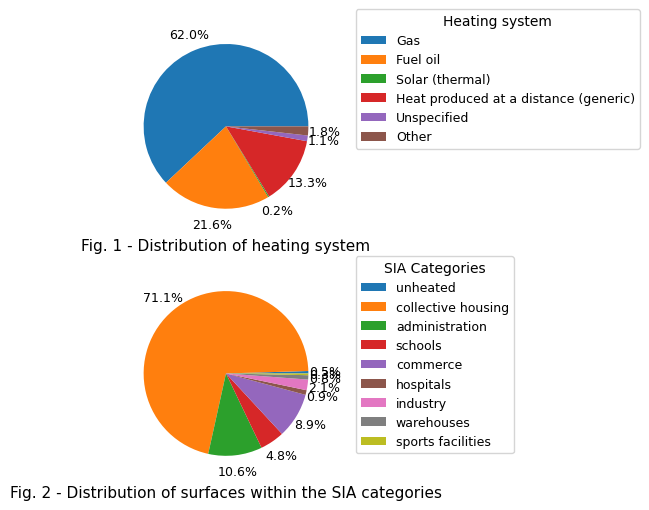

In [11]:
chap_2_1_0 = f"""
<p style='text-align: justify;'>
The uploaded file contained {number_of_rows} buildings and {unique_egid} different EGID numbers. On these {unique_egid} different EGID numbers, the tool was able to estimate the heat demand of {number_of_rows_2}.<br>
The total estimated energy reference area (ERA) of these buildings amounts to {total_surface_list} m<sup>2</sup>, of which approximately {percentage_heated}% are heated surfaces. On these {number_of_rows_2} buildings on which the tool was able to work, the tool estimates the total ERA at {total_surface_tessa} m<sup>2</sup>, 
that is to say approximately {percentage_era_tessa_list}%.</p><br>

The two figures below illustrate, on the one hand, the distribution of the heating systems and, on the other hand, the distribution of the surfaces according to the SIA categories:
"""
display(Markdown(chap_2_1_0))
plot_camemberts_cat_sia_surface_heating(buildings)

In [12]:
Markdown(f"""
Interestingly, there is great potential to decarbonize heat generation systems given that approximately {percentage_fossil_chaudiere} % of buildings are supplied with fossil energy (gas and oil).
These results do not really make sense in this specific case study, as all or almost all of the buildings should be without fossil boilers since they should be connected to the District Heating.
This shows that the RegBL data is not up to date.</p>
""")


Interestingly, there is great potential to decarbonize heat generation systems given that approximately 84 % of buildings are supplied with fossil energy (gas and oil).
These results do not really make sense in this specific case study, as all or almost all of the buildings should be without fossil boilers since they should be connected to the District Heating.
This shows that the RegBL data is not up to date.</p>



For all these buildings, the total annual heat demand is estimated at 108 GWh. The demand for domestic hot water represents about 25 % of this total demand. </p>
However, this split between domestic hot water and space heating varies depending on the SIA category and the period of construction as illustrated in the figure below: </p>


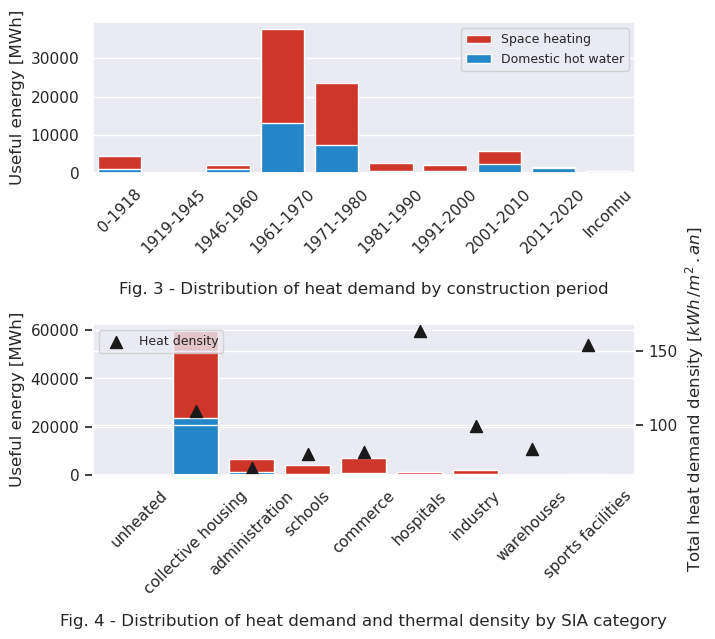

In [13]:
chap_2_1_3 = f"""
For all these buildings, the total annual heat demand is estimated at {total_heat_demand_GWh} GWh. The demand for domestic hot water represents about {percentage_ecs} % of this total demand. </p>
However, this split between domestic hot water and space heating varies depending on the SIA category and the period of construction as illustrated in the figure below: </p>
"""
display(Markdown(chap_2_1_3))
plot_histo_cat_sia_construction_demand(buildings)


After estimating the heat demand at the annual level, it is interesting to go into more detail to observe the form that this demand takes throughout the year. 
The graph below illustrates the evolution of the hourly demand for heating and domestic hot water: </p><br>


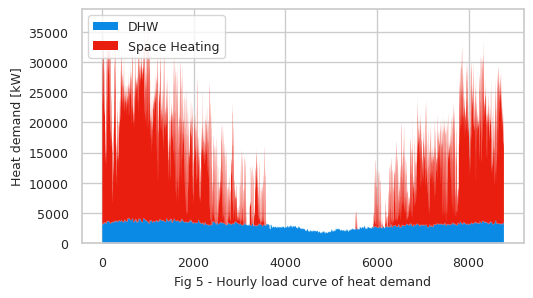


It is interesting to note that for the studied building stock, about 28 % of the year, the heat demand for heating is 0, or 2416 hours. <br>
The table below summarizes the information on heat demand : </p>


In [14]:
chap_2_1_4 = f"""
After estimating the heat demand at the annual level, it is interesting to go into more detail to observe the form that this demand takes throughout the year. 
The graph below illustrates the evolution of the hourly demand for heating and domestic hot water: </p><br>
"""
display(Markdown(chap_2_1_4))
plot_area_load_curve (hourly_load_curve)
chap_2_1_5 = f"""
It is interesting to note that for the studied building stock, about {perce_without_heating} % of the year, the heat demand for heating is 0, or {hours_without_heating} hours. <br>
The table below summarizes the information on heat demand : </p>
"""
display(Markdown(chap_2_1_5))

In [15]:
resume_1 = create_table_summarize (hourly_load_curve, buildings)
resume_1

Pmax [kW]  Yearly Heat demand [GWh]  DUP [h]  CO2 [t. eq.]
Param                                                                    
DHW                 4307                        27     6348          7990
Space Heating      33175                        80     2422         20127
Total              36883                       108     2920         28117

In [16]:
Markdown(f"""
<p style='text-align: justify;'>
At the level of the studied building stock, the CO2 emissions for the total heating needs are estimated at {round(resume_1.loc["Total",'CO2 [t. eq.]']/total_surface_list*1000)} kg CO2 per m2 and year. </p>
""")


<p style='text-align: justify;'>
At the level of the studied building stock, the CO2 emissions for the total heating needs are estimated at 23 kg CO2 per m2 and year. </p>


### Estimation of the heating district

<p style='text-align: justify;'>    
After having estimated the different heat demands for the studied building stock, it will be a question in this part to present the results concerning the heat district.
On the map below, the route of the modelled heating network is shown: <br>
</p>

In [29]:
flow = FlowProperties()
costs = NetworkCosts()
heat_sources = ThermalSources(sources=[
        ThermalSource(name='Dummy', power_useful=np.Inf, efficiency=1, kg_co2_kwh=0)])
district.thermal_net = DistrictNetwork.from_district(district, 
                                                    app.district_network_builder,
                                                    flow=flow,
                                                    costs=costs,
                                                     heat_sources=heat_sources,
                                                     load_geom=True
                                                     )
# district.thermal_net.geometry = app.district_network_builder.load_network_geometry(district.thermal_net.graph)

/opt/conda/envs/geneap-1/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: divide by zero encountered in power
  fill_value_array = self.func(
/opt/conda/envs/geneap-1/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [31]:
plt.rcParams['savefig.dpi']= 70
map_gui = MapBrowser(engine)
map_gui.layout=Layout(height='300px')
map_gui.thermal_net_layer.update(district.thermal_net)
map_gui

MapBrowser(center=[46.2, 6.14], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [32]:
chap_2_1_7 = f"""
<p style='text-align: justify;'>
The main information of the said heating network is explained below: <br>
<ul>
<li> The length of the network is estimated at {round(district.thermal_net.summary['total_distance'])} meters; </li>
<li> The average linear density is {round(district.thermal_net.summary['mean_linear_heat_density'])} kWh/m.year ; </li>
<li> The average and maximum estimated diameter of the network pipes is {round(district.thermal_net.summary['mean_pipe_diameter']*1000)} and 
{round(district.thermal_net.summary['max_pipe_diameter']*1000)} milimeters ; </li>
<li> The estimated installation cost of the network is {np.round(district.thermal_net.summary['total_cost']/(1000*1000),decimals = 3)} mio CHF, which amounts to {round(district.thermal_net.summary['investment_cost_per_m'])} CHF/m ; </li>
<li> Finally, assuming a discount rate of {district.thermal_net.costs.discount_rate*100} % and a lifetime of {round(district.thermal_net.costs.network_lifetime)} years, the annualized cost of the infrastructure is the annualized cost of the network infrastructure is estimated at {np.round(district.thermal_net.summary['annualised_cost_per_kwh']*100,decimals = 2)} Cts/kWh sold. </li> 
</ul> <br>
Regarding the resources that will be used to feed the heating network, the choices that have been made by the user generate the following production curve :
"""
display(Markdown(chap_2_1_7))


<p style='text-align: justify;'>
The main information of the said heating network is explained below: <br>
<ul>
<li> The length of the network is estimated at 27616 meters; </li>
<li> The average linear density is 3898 kWh/m.year ; </li>
<li> The average and maximum estimated diameter of the network pipes is 107 and 
556 milimeters ; </li>
<li> The estimated installation cost of the network is 24.111 mio CHF, which amounts to 873 CHF/m ; </li>
<li> Finally, assuming a discount rate of 300 % and a lifetime of 40 years, the annualized cost of the infrastructure is the annualized cost of the network infrastructure is estimated at 0.97 Cts/kWh sold. </li> 
</ul> <br>
Regarding the resources that will be used to feed the heating network, the choices that have been made by the user generate the following production curve :


In [38]:
flow = FlowProperties()
costs = NetworkCosts()
heat_sources=ThermalSources(
        sources=[ThermalSource(name='Electricity', power_useful=25, efficiency=1, kg_co2_kwh=0.103),
                 ThermalSource(name='Centrale à cogénération, biogaz agricole', power_useful=375,efficiency=0.9, kg_co2_kwh=0.0205),
                 ThermalSource(name="Chauffage à distance de l'incinération des ordures, moyenne réseaux CH", power_useful=7575, efficiency=0.9,kg_co2_kwh=0.0027),
                 ThermalSource(name='Centrale de chauffage, gaz', power_useful=28500, efficiency=0.9, kg_co2_kwh=0.3140) ])
    
DH = DistrictNetwork.from_district(district, 
                                  app.district_network_builder,
                                  flow=flow,
                                  costs=costs, 
                                  heat_sources=heat_sources, load_geom=True)

/opt/conda/envs/geneap-1/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: divide by zero encountered in power
  fill_value_array = self.func(
/opt/conda/envs/geneap-1/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


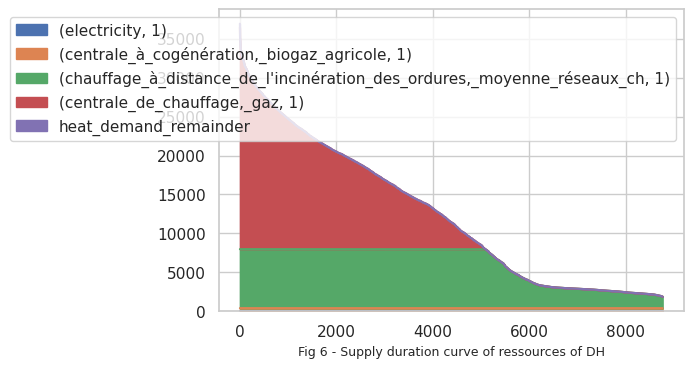

In [39]:
# DH.load_network_geometry(app.database.engine)
DH.heat_sources.supply_duration_curve.plot.area(stacked=True).set_xlabel("Fig 6 - Supply duration curve of ressources of DH", fontsize=9);


<p style='text-align: justify;'>
In percentage terms, the figure below provides the percentage that each resource can supply in the heating network :


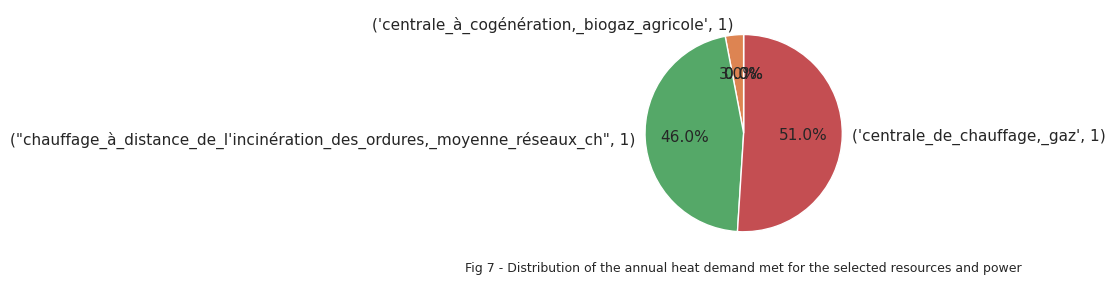

In [40]:
display(Markdown(f"""
<p style='text-align: justify;'>
In percentage terms, the figure below provides the percentage that each resource can supply in the heating network :
"""))
plot_percentage_ressource (DH)

In [41]:
display(Markdown(f"""
<p style='text-align: justify;'>
If all the buildings studied were connected to this heating network, the CO2 emissions would decrease from {round(total_t_co2_before)} to {int(value_co2_cad_sig (DH))} tons, 
which is equivalent to a decrease of {(round((total_t_co2_before-int(value_co2_cad_sig (DH)))/total_t_co2_before*100))} %.<br>
Note that CO2 for pumping electricity has not been taken into account.
"""))


<p style='text-align: justify;'>
If all the buildings studied were connected to this heating network, the CO2 emissions would decrease from 28117 to 0 tons, 
which is equivalent to a decrease of 100 %.<br>
Note that CO2 for pumping electricity has not been taken into account.


## CAD CADIOM - EGID List with annual heat demand

In [46]:
cadiom_egid_demand = pd.read_csv(test_data_path / "cadiom_egid_demand_list.csv", sep=",").set_index('egid')
# set_up_cadiom_list = bd.setup_building_index(cadiom_egid_demand)
district_2 = District.from_buildings(cadiom_egid_demand,
                                               building_data_source=app.building_data_source, 
                                               climate_data_source=app.climate_data_source, 
                                               heat_model=app.heat_model, gen_load_curves=True)

In [50]:
index_3 = cadiom_egid_demand.index
number_of_rows = len(index_3)
unique_egid_2 = len(cadiom_egid_demand)
index_4 = district_2.buildings.index
number_of_rows_3 = len(index_4)
buildings_egid_w_demand = district_2.buildings.copy()
hourly_load_curve_2 = district_2.load_curve.copy()

<p style='text-align: justify;'> 
Using the csv file containing the EGID numbers, as well as the annual heat requests, the results obtained by TESSA vary greatly as shown in the table below:</p>

In [51]:
resume_2 = create_table_summarize (hourly_load_curve_2, buildings_egid_w_demand)
resume_2

Pmax [kW]  Yearly Heat demand [GWh]  DUP [h]  CO2 [t. eq.]
Param                                                                    
DHW                14358                        90     6277         24271
Space Heating     109130                       270     2477         66376
Total             121872                       360     2957         90647

In [52]:
real_cadiom_lc = pd.read_csv(test_data_path / "LC_CADIOM_2015.csv", sep=",")
chap_2_2_1 = f"""
The maximum hourly power estimated for the heating needs is now {round(resume_2.loc["Total",'Pmax [kW]']/resume_1.loc["Total",'Pmax [kW]'])} times higher than initially estimated.
In terms of annual needs, the estimate goes from {resume_1.loc["Total",'Yearly Heat demand [GWh]']} to {resume_2.loc["Total",'Yearly Heat demand [GWh]']} GWh!<br>
In all likelihood, the reality is somewhere in between because according to the CADIOM measured load curve, the consumption was {round(real_cadiom_lc['mw'].sum()/1000)} GWh.
"""
display(Markdown(chap_2_2_1))


The maximum hourly power estimated for the heating needs is now 3 times higher than initially estimated.
In terms of annual needs, the estimate goes from 108 to 360 GWh!<br>
In all likelihood, the reality is somewhere in between because according to the CADIOM measured load curve, the consumption was 159 GWh.
